# IMDB Sentiment Analysis using classic ML approaches

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/josumsc/classic-ml-sentiment-analysis/blob/master/src/IMDB_Sentiment_Analysis.ipynb)

References:
- [Deeplearning.ai NLP Specialization](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/home/welcome)

In [5]:
import string
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Load data

[Download link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [6]:
imdb = pd.read_csv("IMDB Dataset.csv")

In [7]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
train, test = train_test_split(imdb, train_size=0.8, stratify=imdb.sentiment)

In [9]:
counter = train.iloc[:, 1].value_counts()
print(f"The proportion of classes is the following:", counter)

The proportion of classes is the following: positive    20000
negative    20000
Name: sentiment, dtype: int64


In [10]:
print(f"Some examples of positive reviews are:\n{train[train.sentiment=='positive'].sample(5)}")

Some examples of positive reviews are:
                                                  review sentiment
7870   I have to admit to enjoying bad movies. I love...  positive
45540  I thought this was very "different" compared t...  positive
7923   I saw the latter half of this movie about a ye...  positive
33941  Red Skelton was still another major star who m...  positive
30824  This is one of the funniest shows on TV today....  positive


In [11]:
print(f"Some examples of negative reviews are:\n{train[train.sentiment=='negative'].sample(5)}")

Some examples of negative reviews are:
                                                  review sentiment
16077  It's proof that movie makers and their financi...  negative
10850  If you thought Herbie trying to kill himself b...  negative
38592  No words can describe how awful this film is. ...  negative
12409  The TV guide described the plot of SEVERED TIE...  negative
37553  This film tries hard but fails. Perhaps to non...  negative


## Classic ML Approach

### Text preprocessing

While working with text, the first step should be *tokenize* the examples of the corpus and clean the characters that we may not use.

In this case, we will be using a simple word tokenizer, as well as lowering the text, strip the punctuation signs and stopwords and lemmatize the text, so we can reduce the vocabulary of our task and increase the generalization power of the classifiers.

In [12]:
def preprocess_text(
    text: str,
    stopwords: list,
) -> str:
    # Lowercase text
    preprocessed_text = text.lower()

    # Tokenize text
    preprocessed_text = word_tokenize(preprocessed_text)

    # Remove punctuation
    preprocessed_text = [w for w in preprocessed_text if w not in string.punctuation]

    # Remove stopwords
    preprocessed_text = [w for w in preprocessed_text if w not in stopwords]

    # Stem text
    stemmer = PorterStemmer()
    preprocessed_text = [stemmer.stem(w) for w in preprocessed_text]

    return ' '.join(preprocessed_text)

In [13]:
nltk.download('all')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [14]:
example_sentence = train.sample().iloc[0, 0]
print(f"Original Sentence:\n{example_sentence}")
print(f"Preprocessed Sentence:\n{preprocess_text(example_sentence, stopwords)}")

Original Sentence:
Checking Out will be released Friday September 15th, 2006. through the AMC theater chain starting in New York City. Times Square, 66th and 3rd Ave, West 84th Street. This film has been one from the heart, for the heart. Mark Lane, Jon Karas,Richard Marcus, Jeff Hare, Dana Harrloe,Matt Jensen Ed Abrams, Nick Pike, Peter Falk, Laura San Giacomo, David Paymer, Judge Reinhold, all the cast and crew knew from day one that this film was something special. The need to comfort the elderly is intended, the closeness of family is more apparent now then ever. I would recommend this film to all ages and races. This story rings the truth to anyone with or without family.
Preprocessed Sentence:
check releas friday septemb 15th 2006. amc theater chain start new york citi time squar 66th 3rd ave west 84th street film one heart heart mark lane jon kara richard marcu jeff hare dana harrlo matt jensen ed abram nick pike peter falk laura san giacomo david paymer judg reinhold cast crew 

In [15]:
preprocessed_train = train.iloc[:, 0].apply(lambda x: preprocess_text(x, stopwords))
preprocessed_test = test.iloc[:, 0].apply(lambda x: preprocess_text(x, stopwords))

In [16]:
y_train = np.where(train.sentiment=='positive', 1, 0)
y_test = np.where(test.sentiment=='positive', 1, 0)

### Logistic Regression

For this method, we first need to build a frequency table that will inform us of how many occurrences of a certain token are inside each of the labels to classify, which in this case would be positive and negative reviews.

In [17]:
def get_word_dict(result, X, y):
    for label, sentence in zip(y, X):
        for word in word_tokenize(sentence):
            # define the key, which is the word and label tuple
            pair = (word, label)
            
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1

    return result


freqs = get_word_dict({}, preprocessed_train, y_train)

After building our token table, we must vectorize our examples using it. We will be applying a simple sum as aggregation, as it will provide a reliable score to represent the sentiment of each example:

In [45]:
def extract_features(text, freqs, preprocess=False):
    if preprocess:
      word_l = preprocess_text(text, stopwords)
    else:
      word_l = word_tokenize(text)

    x = np.zeros((1, 3))
    #bias term is set to 1
    x[0, 0] = 1 
    
    # loop through each token
    for word in word_l:
        if (word, 1.0) in freqs.keys():
            x[0, 1] += freqs[(word, 1.0)]
        if (word, 0.0) in freqs.keys():
            x[0, 2] += freqs[(word, 0.0)]
    return x


X_train = np.zeros((len(preprocessed_train), 3))
for i, row in enumerate(preprocessed_train.values):
    X_train[i, :]= extract_features(row, freqs)

X_test = np.zeros((len(preprocessed_test), 3))
for i, row in enumerate(preprocessed_test.values):
    X_test[i, :]= extract_features(row, freqs)

Later on, we may apply the `LogisticRegression` class from *sklearn* to fit a classifier that would learn a *bias* term and the coefficients of the scores of each class for the example to be classified:

In [52]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_preds = log_model.predict(X_test)
print(f"Results of the Logistic Regression model:\n", classification_report(y_test, y_preds))

Results of the Logistic Regression model:
               precision    recall  f1-score   support

           0       0.68      0.71      0.69      5000
           1       0.70      0.67      0.68      5000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



In [51]:
custom_input = "This movie is terrible, boring and predictable"
new_example = extract_features(custom_input, freqs, preprocess=True)
output = log_model.predict_proba(new_example)
print(output)

[0]


### Naive Bayes Classifier

As a second traditional method, we select [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). This method is based on the conditional probability of an example to belong to a certain class given the probabilities of each of the tokens, which will be summarized in what's called *loglikelihoods*. To calculate this probability, we will be using the same frequency table that we calculated for the Logistic Regression:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V} $$

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)$$


Besides, a bias term is fitted which represents the overall likelihood of an example of a certain class to be draft from the corpus. This bias term is called *logprior*.

$$\text{logprior} = \log (D_{pos}) - \log (D_{neg})$$

Finally, after the calculation of these both terms we just need to add them to form the final probability of an example to belong to a particular class, and then perform a *softmax* operation to retrieve the index with the higher probability. As in this case the problem is binary, we can summarize the equation as:

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

In [18]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0

    vocab = {w[0] for w in freqs.keys()}
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            N_pos += freqs[pair]
        # else, the label is negative
        else:
            N_neg += freqs[pair]
    
    D = len(train_x)
    D_pos = train_y[train_y == 1].shape[0]
    D_neg = train_y[train_y == 0].shape[0]

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs[word, 1.0] if (word, 1.0) in freqs.keys() else 0
        freq_neg = freqs[word, 0.0] if (word, 0.0) in freqs.keys() else 0
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood


logprior, loglikelihood = train_naive_bayes(freqs, preprocessed_train, y_train)

In [19]:
def naive_bayes_predict(text, logprior, loglikelihood):
    word_l = word_tokenize(text)

    # start by adding our logprior
    p = 0
    p += logprior

    # words that are not in vocabulary simply get ignored
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    return p


def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    y_hats = []
    for text in test_x:
        if naive_bayes_predict(text, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)

    error = np.mean(np.abs(test_y - y_hats))
    accuracy = 1 - error
    return y_hats, accuracy

In [20]:
y_preds, accuracy = test_naive_bayes(preprocessed_test, y_test, logprior, loglikelihood)
print(f"Results of the Naive Bayes model:\n", classification_report(y_test, y_preds))

Results of the Naive Bayes algorithm:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      5000
           1       0.87      0.83      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [21]:
# inference
custom_input = "This movie is terrible, boring and predictable"
output = naive_bayes_predict(custom_input, logprior, loglikelihood)
print(output)

-7.163884091191697


## Deep Learning Approach

To compare with our previous approaches, we might want to create a more sophisticated model using Deep Learning to take into consideration the order of the different tokens and more complicated relationships between them, as the classic models used the Bag-of-Words approach.

### Building our own Recursive Model

In [22]:
max_words = 10000
max_length = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.review)

X_train = tokenizer.texts_to_sequences(train.review)
X_test = tokenizer.texts_to_sequences(test.review)

X_train_padded = pad_sequences(X_train, max_length, padding="post")
X_test_padded = pad_sequences(X_test, max_length, padding="post")

In [23]:
embedding_dim = 50
units = 25
dropout = .2

batch_size = 256
epochs = 25
validation_split = .2

criterion = "binary_crossentropy"
optimizer = keras.optimizers.Adam(lr=0.001)
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_loss'),
]


model = keras.models.Sequential([
    keras.layers.Embedding(max_words, embedding_dim, input_length = X_train_padded.shape[1]),
    keras.layers.LSTM(units, recurrent_dropout=dropout),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
history = model.fit(
    X_train_padded,
    y_train,
    validation_split=.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
)

Epoch 1/25
125/125 [==============================] - 16s 89ms/step - loss: 0.5330 - accuracy: 0.7357 - val_loss: 0.4012 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 2/25
125/125 [==============================] - 11s 87ms/step - loss: 0.3463 - accuracy: 0.8528 - val_loss: 0.3926 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 3/25
125/125 [==============================] - 11s 87ms/step - loss: 0.2933 - accuracy: 0.8811 - val_loss: 0.4070 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/25
125/125 [==============================] - 11s 86ms/step - loss: 0.2563 - accuracy: 0.8990 - val_loss: 0.4244 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 5/25
125/125 [==============================] - 11s 87ms/step - loss: 0.2253 - accuracy: 0.9116 - val_loss: 0.4452 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 6/25
125/125 [==============================] - 11s 89ms/step - loss: 0.1966 - accuracy: 0.9249 - val_loss: 0.5091 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 7/25
125/125 [==============================] - 11s 

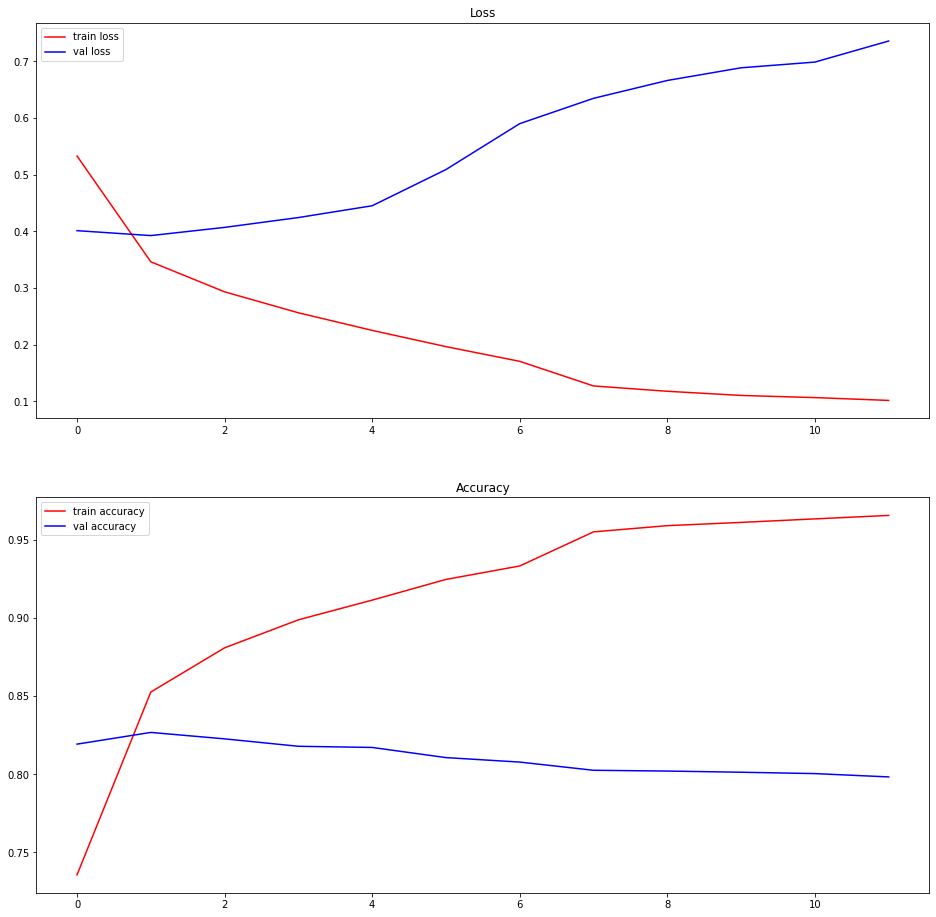

In [25]:
fig, ax = plt.subplots(figsize=(16, 16), nrows=2)
ax[0].plot(history.history['loss'], c='red', label='train loss')
ax[0].plot(history.history['val_loss'], c='blue', label='val loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(history.history['accuracy'], c='red', label='train accuracy')
ax[1].plot(history.history['val_accuracy'], c='blue', label='val accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.show()

In [26]:
model.evaluate(X_test_padded, y_test,)

313/313 [==============================] - 5s 15ms/step - loss: 0.3873 - accuracy: 0.8278


[0.38727542757987976, 0.8277999758720398]

In [27]:
# inference
custom_input = ["This movie is terrible, boring and predictable"]
custom_input = pad_sequences(tokenizer.texts_to_sequences(custom_input), maxlen=max_length)
output = model.predict(custom_input)
print(output)

[[0.0430442]]


We see that even though the model seems to be working quite fine and surpasses the accuracy of the Logistic model, it does not reach the accuracy of a simple Naive Bayes. This fact does not mean that Naive Bayes and preprocessing is better than building a Tokenizer and a recursive neural network, as we should be able to boost the accuracy of the former by tweaking its parameters, but instead could enlighten us on the thought that sometimes classic and simple models are preferable, as their explainability is much higher and their computational cost much lower.